# 03 - Evaluation & Visualization

> Scaffold notebook — fill with data and code.

## Setup

In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve

DATA_DIR = Path("../data/processed")
df = pd.read_csv(DATA_DIR / "shots_with_xg.csv")

df.head(), len(df)


(          team_name                     player_name       location  \
 0         Barcelona  Lionel Andrés Messi Cuccittini  [111.5, 52.9]   
 1         Barcelona                Jordi Alba Ramos  [113.9, 26.4]   
 2         Barcelona  Lionel Andrés Messi Cuccittini   [93.7, 34.7]   
 3  Deportivo Alavés           Rubén Sobrino Pozuelo  [109.2, 39.1]   
 4         Barcelona        Luis Alberto Suárez Díaz  [107.8, 24.7]   
 
   shot_body_part_name shot_outcome_name  under_pressure      x     y  is_goal  \
 0          Right Foot             Off T               0  111.5  52.9        0   
 1           Left Foot             Off T               0  113.9  26.4        0   
 2           Left Foot             Saved               0   93.7  34.7        0   
 3                Head             Off T               1  109.2  39.1        0   
 4          Right Foot             Off T               0  107.8  24.7        0   
 
     distance     angle  body_foot_Left Foot  body_foot_Other  \
 0  15.448625

## Calibration curves

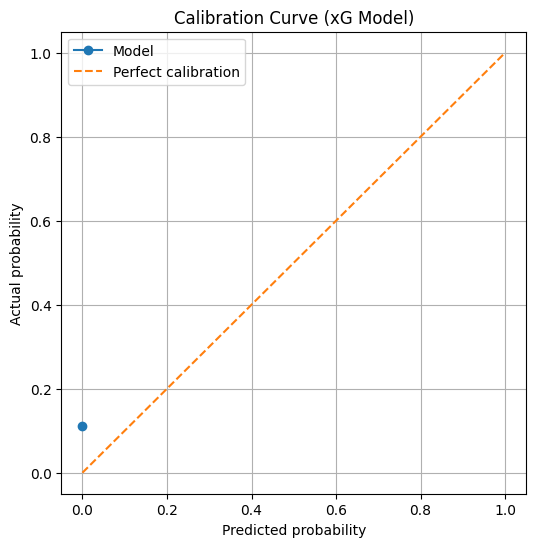

In [2]:
y_true = df["is_goal"]
y_prob = df["xg_model"]

prob_true, prob_pred = calibration_curve(y_true, y_prob, n_bins=10)

plt.figure(figsize=(6,6))
plt.plot(prob_pred, prob_true, marker='o', label="Model")
plt.plot([0,1],[0,1], linestyle='--', label="Perfect calibration")
plt.xlabel("Predicted probability")
plt.ylabel("Actual probability")
plt.title("Calibration Curve (xG Model)")
plt.legend()
plt.grid(True)

fig_dir = Path("../figures")
fig_dir.mkdir(exist_ok=True)

plt.savefig(fig_dir / "calibration_curve.png", dpi=200, bbox_inches="tight")
plt.show()


## Diagnostic plots

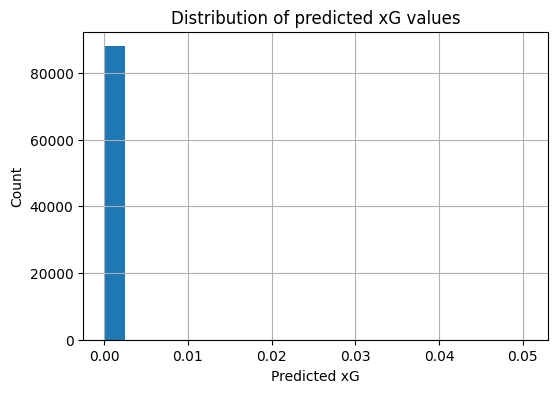

In [3]:
plt.figure(figsize=(6,4))
plt.hist(df["xg_model"], bins=20)
plt.xlabel("Predicted xG")
plt.ylabel("Count")
plt.title("Distribution of predicted xG values")
plt.grid(True)
plt.savefig(fig_dir / "xg_distribution.png", dpi=200, bbox_inches="tight")
plt.show()


## Export figures

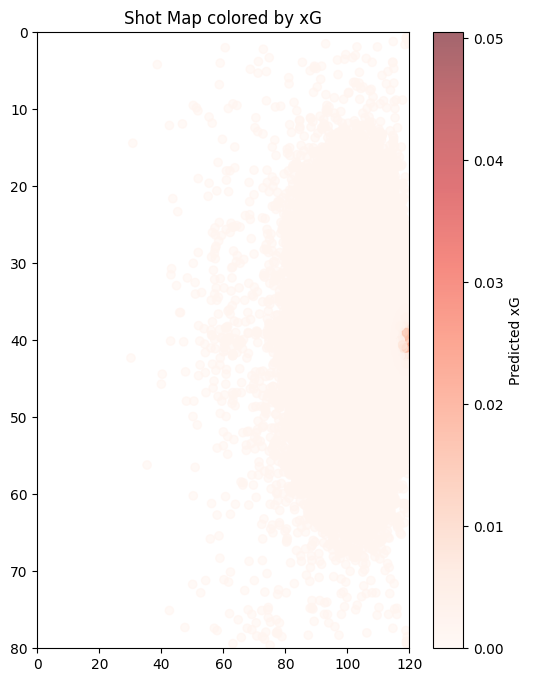

In [4]:
plt.figure(figsize=(6,8))

# Saha kaba çizim (sadece akslar bile yeter)
plt.scatter(df["x"], df["y"], c=df["xg_model"], cmap="Reds", alpha=0.6)
plt.colorbar(label="Predicted xG")
plt.xlim(0, 120)
plt.ylim(0, 80)
plt.gca().invert_yaxis()  # StatsBomb y ekseni terstir
plt.title("Shot Map colored by xG")
plt.savefig(fig_dir / "shotmap.png", dpi=200, bbox_inches="tight")
plt.show()
